# Calculating Lagrangian trajectories for coupled simulation

## Loading modules

In [1]:
%matplotlib inline
from parcels import (FieldSet, ParticleSet,
                     JITParticle, ScipyParticle,
                     AdvectionRK4,
                     Variable, Field, VectorField)
from glob import glob
import xarray as xr
import numpy as np
from datetime import timedelta, datetime
import math

## Custom settings
need to be checked/adjusted before every execution

In [2]:
# DEFINE INPUT AND OUTPUT PATHS

############################

# set key to 'uncoupled', 'coupled_nosd', or 'coupled_sd'
key_input = 'uncoupled'

# define whether along-track wind stress is sampled (key_sample_tau = True)
key_sample_tau = True

# define whether ocean velocity is sampled (key_sample_velocity = True)
key_sample_velocity = True

############################

datapath = '/Users/siren/Data/IMMERSE/'

gridpath = (datapath + 'domain/fgrid.nc')

if key_input == 'uncoupled':
    filepaths_u = sorted(glob(datapath + 'surface_TKE_v42RC/MED24_OBC_1d*_grid_U.nc'))
    filepaths_v = sorted(glob(datapath + 'surface_TKE_v42RC/MED24_OBC_1d*_grid_V.nc'))
    key_stokes = False
    print('calculate trajectories for uncoupled simulation')

elif key_input == 'coupled_nosd' or key_input == 'coupled_sd':
    filepaths_u = sorted(glob(datapath + 'surface_TKE_CO_FORCE_MIX_LC015/MED24_OBC_1d*_grid_U.nc'))
    filepaths_v = sorted(glob(datapath + 'surface_TKE_CO_FORCE_MIX_LC015/MED24_OBC_1d*_grid_V.nc'))
    if key_input == 'coupled_nosd':
        key_stokes = False
        print('calculate trajectories for coupled simulation without explicit consideration of Stokes drift')
    elif key_input == 'coupled_sd':
        key_stokes = True
        print('calculate trajectories for coupled simulation with explicit consideration of Stokes drift')

else:
    print('no (valid) key_input defined')

calculate trajectories for uncoupled simulation


In [3]:
# DEFINE PARTICLE RELEASE GRID

############################

release_name = 'GulfOfLion'
#lonmin = 3
#lonmax = 4.5
#latmin = 42
#latmax = 43.5
#step = 0.25
lonmin = 3
lonmax = 4
latmin = 42
latmax = 43
step = 0.5

tstart_release = 0 
deltat_release = 5 # days: release from the same set of locations every deltat_release days
tend_release = 5 #days
#tend_release = 365 #days

############################

lons, lats = np.meshgrid(np.arange(lonmin, lonmax+step, step),
                         np.arange(latmin, latmax+step, step))
n_releasepos = lons.shape[0]*lons.shape[1]
n_particles = n_releasepos * ((tend_release-tstart_release)/deltat_release)
print('maximum number of release positions (including land):', n_releasepos)
print('maximum number of particles (including land):', int(n_particles))

maximum number of release positions (including land): 9
maximum number of particles (including land): 9


In [37]:
# DEFINE TRAJECTORY INTEGRATION PARAMETERS

############################

tint = 5 # days
deltat = 25 # minutes
# How to chose deltat (Schmidt et al., 2021):
### The time step dt should be small enough that particles do not skip grid cells
### and thereby miss characteristic oceanographic features. 
### Due to trade-off between accuracy of time stepping and computation time, the integration
### time step dt was chosen such that particles stay in one model grid cell for at least 2dt
### Therefore, a time step dt can be calculated following dt<dsmin/(vmax⋅2)
### where dsmin is the smallest edge of all grid cells in the domain and
### vmax is the largest horizontal velocity.
### assume vmax = 1m/s, dsmin = 1/24 = 3000 m : dt < (3000 / 2)s = 1500 s = 25 min 
### (at 45N - northern boundary MedSea - 1deg lon is appr. 79km -> 1/24 deg = 3.3 km;
### 1 deg lat is 111km)

pclass = JITParticle # can be JITParticle or ScipyParticle

#############################

In [5]:
# DEFINE LAGRANGIAN OUTPUT

############################

outdt = 1 #days
procpath = '/Users/siren/IMMERSE_waves/develop-mac/data/Test/'

############################

if key_input == 'uncoupled':
    outpath = (procpath + 'Parcels_CalcTraj_Data-uncoupled_Release-' + release_name)
elif key_input == 'coupled_nosd':
    outpath = (procpath + 'Parcels_CalcTraj_Data-coupled-nosd_Release-' + release_name)
elif key_input == 'coupled_sd':
    outpath = (procpath + 'Parcels_CalcTraj_Data-coupled-sd_Release-' + release_name)

## Create fieldset

In [6]:
filenames = {'U': {'lon': gridpath, 'lat': gridpath, 'data': filepaths_u},
             'V': {'lon': gridpath, 'lat': gridpath, 'data': filepaths_v}}
variables = {'U': 'vozocrtx',
             'V': 'vomecrty'}
dimensions = {'U': {'lon': 'glamf', 'lat': 'gphif', 'time': 'time_counter'},
              'V': {'lon': 'glamf', 'lat': 'gphif', 'time': 'time_counter'}}

fieldset = FieldSet.from_nemo(filenames, variables, dimensions,
                              mesh='spherical',
                              allow_time_extrapolation=False,
                              time_periodic=False)

In [7]:
if key_stokes==True:
    variables_sd = {'U': 'usd',
                    'V': 'vsd'}
    fieldset_sd = FieldSet.from_nemo(filenames, variables_sd, dimensions,
                                     mesh='spherical',
                                     allow_time_extrapolation=False,
                                     time_periodic=False)
    fieldset_sum = FieldSet(U=fieldset.U+fieldset_sd.U,
                            V=fieldset.V+fieldset_sd.V)
    fieldset_use = fieldset_sum
    
else:
    fieldset_use = fieldset

In [8]:
if key_sample_tau == True:
    
    taux_data = xr.open_mfdataset(filepaths_u).sozotaux
    tauy_data = xr.open_mfdataset(filepaths_v).sometauy
    
    field_taux = Field('taux', taux_data,
                   grid=fieldset.U.grid,
                   fieldtype='U',
                   interp_method='cgrid_velocity',
                   mesh='spherical',
                   allow_time_extrapolation=False,
                   time_periodic=False) 
    field_tauy = Field('tauy', tauy_data,
                   grid=fieldset.V.grid,
                   fieldtype='V',
                   interp_method='cgrid_velocity',
                   mesh='spherical',
                   allow_time_extrapolation=False,
                   time_periodic=False) 
    vfield_tau = VectorField('tau', field_taux, field_tauy)
    
    fieldset_use.add_vector_field(vfield_tau)

## Build and execute particle set

### Define custom Kernels and functions

Kernels partially adopted and modified from https://github.com/OceanParcels/Parcelsv2.0PaperNorthSeaScripts

In [38]:
class BeachParticle(pclass):
    # beached : 0 sea, 1 beached, 2 after non-beach dyn
    beached = Variable('beached', dtype=np.int64, initial=2)

In [39]:
class BeachWindParticle(pclass):
    # beached : 0 sea, 1 beached, 2 after non-beach dyn
    beached = Variable('beached', dtype=np.int64, initial=0)
    taux = Variable('taux', dtype=np.float32, initial=0)
    tauy = Variable('tauy', dtype=np.float32, initial=0)

In [40]:
class BeachCurrentParticle(pclass):
    # beached : 0 sea, 1 beached, 2 after non-beach dyn
    beached = Variable('beached', dtype=np.int64, initial=0)
    U = Variable('U', dtype=np.float32, initial=0)
    V = Variable('V', dtype=np.float32, initial=0)

In [41]:
class BeachWindCurrentParticle(pclass):
    # beached : 0 sea, 1 beached, 2 after non-beach dyn
    beached = Variable('beached', dtype=np.int64, initial=0)
    taux = Variable('taux', dtype=np.float32, initial=0)
    tauy = Variable('tauy', dtype=np.float32, initial=0)
    U = Variable('U', dtype=np.float32, initial=0)
    V = Variable('V', dtype=np.float32, initial=0)

In [42]:
def AdvectionRK4(particle, fieldset, time):
    if particle.beached == 0:
        (u1, v1) = fieldset.UV[time, particle.depth, particle.lat, particle.lon]
        lon1, lat1 = (particle.lon + u1*.5*particle.dt, particle.lat + v1*.5*particle.dt)

        (u2, v2) = fieldset.UV[time + .5 * particle.dt, particle.depth, lat1, lon1]
        lon2, lat2 = (particle.lon + u2*.5*particle.dt, particle.lat + v2*.5*particle.dt)

        (u3, v3) = fieldset.UV[time + .5 * particle.dt, particle.depth, lat2, lon2]
        lon3, lat3 = (particle.lon + u3*particle.dt, particle.lat + v3*particle.dt)

        (u4, v4) = fieldset.UV[time + particle.dt, particle.depth, lat3, lon3]
        particle.lon += (u1 + 2*u2 + 2*u3 + u4) / 6. * particle.dt
        particle.lat += (v1 + 2*v2 + 2*v3 + v4) / 6. * particle.dt
        particle.beached = 2

In [43]:
def SampleUV(particle, fieldset, time):
    # attention: samples particle velocity in deg/s and needs to be converted to m/s
    particle.U, particle.V = fieldset.UV[time, particle.depth, particle.lat, particle.lon]
    #particle.U, particle.V = fieldset.UV.eval(time, particle.depth, particle.lat, particle.lon, applyConversion=False)

In [44]:
def SampleTau(particle, fieldset, time):
    particle.taux, particle.tauy = fieldset.tau[time, particle.depth, particle.lat, particle.lon]

In [45]:
def BeachTesting(particle, fieldset, time):
    if particle.beached == 2:
        (u, v) = fieldset.UV[time, particle.depth, particle.lat, particle.lon]
        if math.fabs(u) < 1e-8 and math.fabs(v) < 1e-8:
            particle.beached = 1
            print("Particle [%d] beached !! (%g %g %g %g)" % (particle.id, particle.lon, particle.lat, particle.depth, particle.time))
        else:
            particle.beached = 0

In [46]:
def DeleteParticle(particle, fieldset, time):
    if particle.beached == 1:
        particle.delete()
        print("Particle [%d] deleted !! (%g %g %g %g)" % (particle.id, particle.lon, particle.lat, particle.depth, particle.time))

In [47]:
def PlotParticleSet(pset,fieldset):
    plotstep=4
    pset.show(field=fieldset.U,
              domain={'N':(latmax+plotstep/2),'S':(latmin-plotstep),
                      'E': (lonmax+plotstep), 'W':(lonmin-plotstep)})

### Determine particle release positions

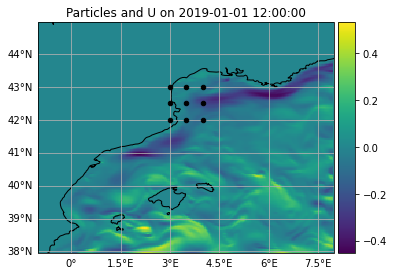

maximum number of release positions (including land): 9



In [48]:
# release particles on predefined uniform grid, including land grid points
pset = ParticleSet(fieldset=fieldset_use,
                   pclass=BeachParticle,
                   lon=lons, lat=lats, time=0)
pset.populate_indices()
PlotParticleSet(pset,fieldset)
print('maximum number of release positions (including land):',pset.lon.size)
print()

In [49]:
# perform a "fake" integration to determine and delete particles released on land
## by making use of beach-testing and deleting kernels
## (without advection kernel)
kernels_init = pset.Kernel(BeachTesting) + pset.Kernel(DeleteParticle)
pset.execute(kernels_init, dt=0)
PlotParticleSet(pset,fieldset)

RuntimeError: Error during compilation:
Compilation command: x86_64-apple-darwin13.4.0-clang -Wall -fPIC -std=gnu11 -I/Users/siren/opt/miniconda3/envs/py3_parcels/lib/python3.10/site-packages/parcels/include -I. -g -O3 -DDOUBLE_COORD_VARIABLES -m64 -o /var/folders/bd/ct5yrfy51z7bdshm97c2w2nc0000gp/T/parcels-502/libe4a8a81ed1a3b2e793ad38ff59d16e84_0.so /var/folders/bd/ct5yrfy51z7bdshm97c2w2nc0000gp/T/parcels-502/e4a8a81ed1a3b2e793ad38ff59d16e84_0.c -shared -lm -m64
Source/Destination file: /var/folders/bd/ct5yrfy51z7bdshm97c2w2nc0000gp/T/parcels-502/e4a8a81ed1a3b2e793ad38ff59d16e84_0.c
Log file: /var/folders/bd/ct5yrfy51z7bdshm97c2w2nc0000gp/T/parcels-502/e4a8a81ed1a3b2e793ad38ff59d16e84_0.log

Log output: /var/folders/bd/ct5yrfy51z7bdshm97c2w2nc0000gp/T/parcels-502/e4a8a81ed1a3b2e793ad38ff59d16e84_0.c:108:62: warning: format specifies type 'int' but the argument has type 'long' [-Wformat]
          printf("Particle [%d] beached !! (%g %g %g %g)\n", particles->id[pnum], particles->lon[pnum], particles->lat[pnum], particles->depth[pnum], particles->time[pnum]);;
                            ~~                               ^~~~~~~~~~~~~~~~~~~
                            %ld
/var/folders/bd/ct5yrfy51z7bdshm97c2w2nc0000gp/T/parcels-502/e4a8a81ed1a3b2e793ad38ff59d16e84_0.c:123:58: warning: format specifies type 'int' but the argument has type 'long' [-Wformat]
      printf("Particle [%d] deleted !! (%g %g %g %g)\n", particles->id[pnum], particles->lon[pnum], particles->lat[pnum], particles->depth[pnum], particles->time[pnum]);;
                        ~~                               ^~~~~~~~~~~~~~~~~~~
                        %ld
2 warnings generated.
ld: unsupported tapi file type '!tapi-tbd' in YAML file '/Library/Developer/CommandLineTools/SDKs/MacOSX.sdk/usr/lib/libm.tbd' for architecture x86_64
clang-12: error: linker command failed with exit code 1 (use -v to see invocation)


In [35]:
# retrieve lon and lats from all ocean release positions
print('actual number of release positions (excluding land):', pset.lon.size)
print('actual number of particles:',
      pset.lon.size * ((tend_release-tstart_release)/deltat_release))
lons_use = pset.lon
lats_use = pset.lat

actual number of release positions (excluding land): 6
actual number of particles: 6.0


### Perform trajectory integration

INFO: Temporary output files are stored in /Users/siren/IMMERSE_waves/develop-mac/data/Test/out-CLJKNVGU.
INFO: You can use "parcels_convert_npydir_to_netcdf /Users/siren/IMMERSE_waves/develop-mac/data/Test/out-CLJKNVGU" to convert these to a NetCDF file during the run.
100% (432000.0 of 432000.0) |############| Elapsed Time: 0:00:57 Time:  0:00:57


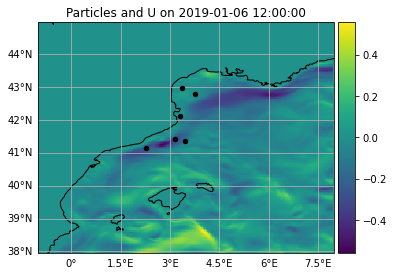

In [36]:
for times in range(tstart_release, tend_release, deltat_release):
    
    if key_sample_tau == True & key_sample_velocity == True:
        pclass_use = BeachWindCurrentParticle
        outpath_ending = 'm_Sample-tau-UV.nc'
    elif key_sample_tau == True & key_sample_velocity == False:
        pclass_use = BeachWindParticle
        outpath_ending = 'm_Sample-tau.nc'
    elif key_sample_tau == False & key_sample_velocity == True:
        pclass_use = BeachCurrentParticle
        outpath_ending = 'm_Sample-UV.nc'
    else:
        pclass_use=BeachParticle
        outpath_ending = 'm.nc'
  
    ## create new clean particle set
    pset2 = ParticleSet(fieldset=fieldset_use,
                        pclass=pclass_use,
                        lon=lons_use, lat=lats_use,
                        time=times)   
    pset2.populate_indices()
    
    ## define output
    ### ensure depth is not stored in trajectory output (depth not necessary for 2D calculations)
    pset2.set_variable_write_status('depth', False) 
    outpath_final = (outpath + '-d' + str(times) + '_Integrate-fw-d' + str(tint) + '-dt' + str(deltat) 
                     + outpath_ending)
    outfile_final = pset2.ParticleFile(outpath_final, 
                                       outputdt=timedelta(days=outdt))
  
    ## advect particle
    ## do not delete beached particles, but keep them for statistics
    if key_sample_tau == True & key_sample_velocity == True:
        kernels_main = pset2.Kernel(AdvectionRK4) + pset2.Kernel(BeachTesting) + pset2.Kernel(SampleTau) + pset2.Kernel(SampleUV)
    elif key_sample_tau == True & key_sample_velocity == False:
        kernels_main = pset2.Kernel(AdvectionRK4) + pset2.Kernel(BeachTesting) + pset2.Kernel(SampleTau)
    elif key_sample_tau == False & key_sample_velocity == True:
        kernels_main = pset2.Kernel(AdvectionRK4) + pset2.Kernel(BeachTesting) + pset2.Kernel(SampleUV)
    else:
        kernels_main = pset2.Kernel(AdvectionRK4) + pset2.Kernel(BeachTesting)
    pset2.execute(kernels_main,
                  runtime=timedelta(hours=(tint*24)),
                  dt=timedelta(minutes=deltat),
                  output_file=outfile_final)
    if times == tstart_release:
        PlotParticleSet(pset2,fieldset)
        
    outfile_final.export()
    outfile_final.close()
    
    pset2.set_variable_write_status('depth', True) # somehow needed, otherwise next pset can not be build